In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as ax
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d
from dg_maxwell import msh_parser
from dg_maxwell import isoparam

af.set_backend(params.backend)

/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1187: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1214: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


gmshtranslator friendly reminder: rules and actions prototypes


def node_condition(tag,x,y,z,physgroups): 
def node_action(tag,x,y,z):
def element_condition(eletag,eletype,physgrp,nodes):
def element_action(eletag,eletype,physgrp,nodes):


In [2]:
N_LGL = 8
xi_LGL  = af.np_to_af_array(np.array(lagrange.LGL_points(N_LGL)))
eta_LGL = af.np_to_af_array(np.array(lagrange.LGL_points(N_LGL)))

Xi, Eta = utils.af_meshgrid(xi_LGL, eta_LGL)

eta = af.tile(eta_LGL, N_LGL)
xi = af.flat(af.transpose(af.tile(xi_LGL, 1, N_LGL)))

_, L_p = lagrange.lagrange_polynomials(xi_LGL)
_, L_q = lagrange.lagrange_polynomials(eta_LGL)

L_p = af.np_to_af_array(L_p)
L_q = af.np_to_af_array(L_q)

/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1187: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/bala/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1214: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [3]:
dLp_dxi  = utils.polynomial_derivative(L_p)
dLq_deta = utils.polynomial_derivative(L_q)

In [4]:
nodes, elements = msh_parser.read_order_2_msh('read_and_plot_mesh/mesh/square.msh')

gmshTranslator: Initializing...
gmshTranslator: Mesh has 49 nodes.
gmshTranslator: Mesh has 25 elements.
gmshTranslator: Processed 78 lines.
gmshTranslator: There are 1 physical groups available: 
gmshTranslator:      > 0
gmshTranslator: Parsing nodes
gmshTranslator: Parsing elements
gmshTranslator: No rules for elements... skipping elements.
gmshTranslator: Parsing nodes
gmshTranslator: No rules for nodes... skipping nodes.
gmshTranslator: Parsing elements


In [5]:
dxi_dx  = 1 / w2d.dx_dxi(nodes[elements[0]][:, 0], xi, eta)
dxi_dy  = 1 / w2d.dy_dxi(nodes[elements[0]][:, 1], xi, eta)
deta_dx = 1 / w2d.dx_deta(nodes[elements[0]][:, 0], xi, eta)
deta_dy = 1 / w2d.dy_deta(nodes[elements[0]][:, 1], xi, eta)

In [6]:
def F_xi(u):
    '''
    '''
    dxi_dx  = w2d.dxi_dx(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi, eta)
    dxi_dy  = w2d.dxi_dy(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi, eta)
    
    return w2d.F_x(u) * dxi_dx + w2d.F_y(u) * dxi_dy

def F_eta(u):
    '''
    '''
    deta_dx = w2d.deta_dx(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi, eta)
    deta_dy = w2d.deta_dy(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi, eta)    
    
    return w2d.F_x(u) * deta_dx + w2d.F_y(u) * deta_dy

gmshTranslator: Ending


In [7]:
def g_dd(x_nodes, y_nodes, xi, eta):
    '''
    '''
    ans00  =   (w2d.dx_dxi(x_nodes, xi, eta))**2 \
             + (w2d.dy_dxi(y_nodes, xi, eta))**2
    ans11  =   (w2d.dx_deta(x_nodes, xi, eta))**2 \
             + (w2d.dy_deta(y_nodes, xi, eta))**2
    
    ans01  =  (w2d.dx_dxi(x_nodes, xi, eta))  \
            * (w2d.dx_deta(x_nodes, xi, eta)) \
            + (w2d.dy_dxi(y_nodes, xi, eta))  \
            * (w2d.dy_deta(y_nodes, xi, eta))
    
    ans =  [[ans00, ans01],
            [ans01, ans11]
           ]
    
    return ans


def g_uu(x_nodes, y_nodes, xi, eta):
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    det = (a*d - b*c)
    
    ans = [[d / det, -b / det],
           [-c / det, a / det]]
    
    return ans


def sqrtgDet(x_nodes, y_nodes, xi, eta):
    '''
    '''
    gCov = g_dd(x_nodes, y_nodes, xi, eta)
    
    a = gCov[0][0]
    b = gCov[0][1]
    c = gCov[1][0]
    d = gCov[1][1]
    
    return (a*d - b*c)**0.5


In [8]:
g_ab = g_uu(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi, eta)

In [9]:
x = []
y = []

X = []
Y = []

u_init = []
u_init_mesh = []


for element in elements:
    x.append(af.np_to_af_array(isoparam.isoparam_x_2D(nodes[element][:, 0], np.array(Xi), np.array(Eta))))
    y.append(af.np_to_af_array(isoparam.isoparam_x_2D(nodes[element][:, 1], np.array(Xi), np.array(Eta))))

    X.append(af.np_to_af_array(isoparam.isoparam_x_2D(nodes[element][:, 0], np.array(Xi), np.array(Eta))))
    Y.append(af.np_to_af_array(isoparam.isoparam_x_2D(nodes[element][:, 1], np.array(Xi), np.array(Eta))))

    x[-1] = af.moddims(x[-1], d0 = N_LGL * N_LGL, d1 = 1)
    y[-1] = af.moddims(y[-1], d0 = N_LGL * N_LGL, d1 = 1)

    u_init.append(np.e ** (-(x[-1]**2 + y[-1]**2) / 0.4**2))
    u_init_mesh.append(af.moddims(u_init[-1], d0 = N_LGL, d1 = N_LGL))

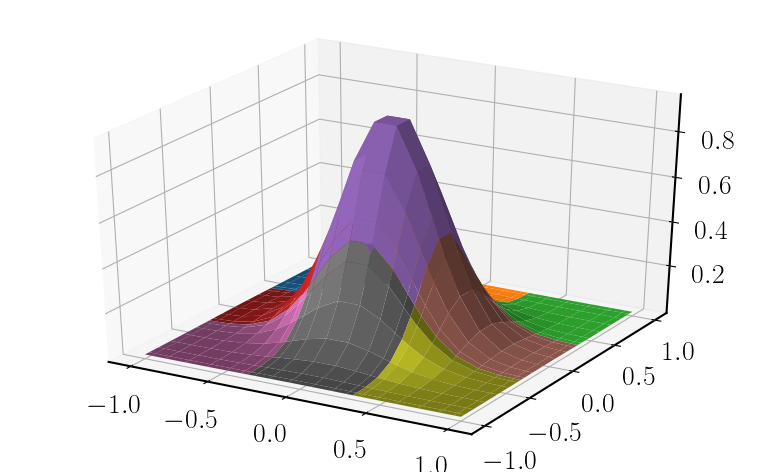

In [11]:
print(u_init)

[arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,)]


In [12]:
L_p_array = af.moddims(af.tile(af.transpose(af.reorder(L_p, d0 = 0, d1 = 2, d2 = 1)),
                               d0 = N_LGL), d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
L_p_array = af.reorder(L_p_array, d0 = 0, d1 = 2, d2 = 1)

L_q_array = af.tile(L_p, d0 = N_LGL)

dLp_dxi_array = af.moddims(af.tile(af.transpose(af.reorder(dLp_dxi, d0 = 0, d1 = 2, d2 = 1)),
                               d0 = N_LGL), d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL - 1)
dLp_dxi_array = af.reorder(dLp_dxi_array, d0 = 0, d1 = 2, d2 = 1)

dLq_deta_array = af.tile(dLq_deta, d0 = N_LGL)

In [13]:
L_p_LGL      = utils.polyval_1d(L_p_array,      xi)
L_q_LGL      = utils.polyval_1d(L_q_array,      eta)
dLp_dxi_LGL  = utils.polyval_1d(dLp_dxi_array , xi)
dLq_deta_LGL = utils.polyval_1d(dLq_deta_array, eta)

In [14]:
F_xi_LGL  = F_xi(u_init[0])
F_eta_LGL = F_eta(u_init[0])

In [15]:
print(af.tile(af.transpose(g_ab[0][0]), d0 = N_LGL * N_LGL).shape)
print(L_p_LGL.shape)
print(dLq_deta_LGL.shape)
print(af.tile(af.transpose(F_xi_LGL), d0 = N_LGL * N_LGL).shape)

(64, 64)
(64, 64)
(64, 64)
(64, 64)


In [16]:
integrand_00 = af.tile(af.transpose(g_ab[0][0]), d0 = N_LGL * N_LGL) * L_q_LGL * dLp_dxi_LGL * af.tile(af.transpose(F_xi_LGL), d0 = N_LGL * N_LGL)
integrand_01 = af.tile(af.transpose(g_ab[0][1]), d0 = N_LGL * N_LGL) * L_p_LGL * dLq_deta_LGL * af.tile(af.transpose(F_eta_LGL), d0 = N_LGL * N_LGL)
integrand_10 = af.tile(af.transpose(g_ab[1][0]), d0 = N_LGL * N_LGL) * L_q_LGL * dLp_dxi_LGL * af.tile(af.transpose(F_xi_LGL), d0 = N_LGL * N_LGL)
integrand_11 = af.tile(af.transpose(g_ab[1][1]), d0 = N_LGL * N_LGL) * L_p_LGL * dLq_deta_LGL * af.tile(af.transpose(F_eta_LGL), d0 = N_LGL * N_LGL)

integrand = integrand_00 + integrand_01 + integrand_10 + integrand_11

In [17]:
integrand[0]

arrayfire.Array()
Type: double
Dims: (1, 64)

In [18]:
print(integrand.shape)
integrand_test = af.reorder(integrand[0], d0 = 1, d1 = 2, d2 = 0)

(64, 64)


In [19]:
integrand_test * utils.integrate_2d(L_p_array, L_q_array, order = 9)

arrayfire.Array()
Type: double
Dims: (64,)

In [20]:
print(X[0], Y[0], u_init_mesh[0], u_init[0])

arrayfire.Array()
Type: double

[8 8 1 1]
   -1.0000    -0.9572    -0.8639    -0.7364    -0.5969    -0.4694    -0.3761    -0.3333 
   -1.0000    -0.9572    -0.8639    -0.7364    -0.5969    -0.4694    -0.3761    -0.3333 
   -1.0000    -0.9572    -0.8639    -0.7364    -0.5969    -0.4694    -0.3761    -0.3333 
   -1.0000    -0.9572    -0.8639    -0.7364    -0.5969    -0.4694    -0.3761    -0.3333 
   -1.0000    -0.9572    -0.8639    -0.7364    -0.5969    -0.4694    -0.3761    -0.3333 
   -1.0000    -0.9572    -0.8639    -0.7364    -0.5969    -0.4694    -0.3761    -0.3333 
   -1.0000    -0.9572    -0.8639    -0.7364    -0.5969    -0.4694    -0.3761    -0.3333 
   -1.0000    -0.9572    -0.8639    -0.7364    -0.5969    -0.4694    -0.3761    -0.3333 

 arrayfire.Array()
Type: double

[8 8 1 1]
    0.3333     0.3333     0.3333     0.3333     0.3333     0.3333     0.3333     0.3333 
    0.3761     0.3761     0.3761     0.3761     0.3761     0.3761     0.3761     0.3761 
    0.4694     0.4694   

In [21]:
foo = np.arange(4)
bar = np.arange(4)

foo, bar = np.meshgrid(foo, bar)
foo = af.np_to_af_array(foo)
bar = af.np_to_af_array(bar)

foo = af.moddims(foo, d0 = 4 * 4, d1 = 1)
bar = af.moddims(bar, d0 = 4 * 4, d1 = 1)

# print(foo)
# print(bar)

print(af.moddims(foo, d0 = 4, d1 = 4))
print(af.moddims(bar, d0 = 4, d1 = 4))


arrayfire.Array()
Type: long int

[4 4 1 1]
         0          1          2          3 
         0          1          2          3 
         0          1          2          3 
         0          1          2          3 


arrayfire.Array()
Type: long int

[4 4 1 1]
         0          0          0          0 
         1          1          1          1 
         2          2          2          2 
         3          3          3          3 




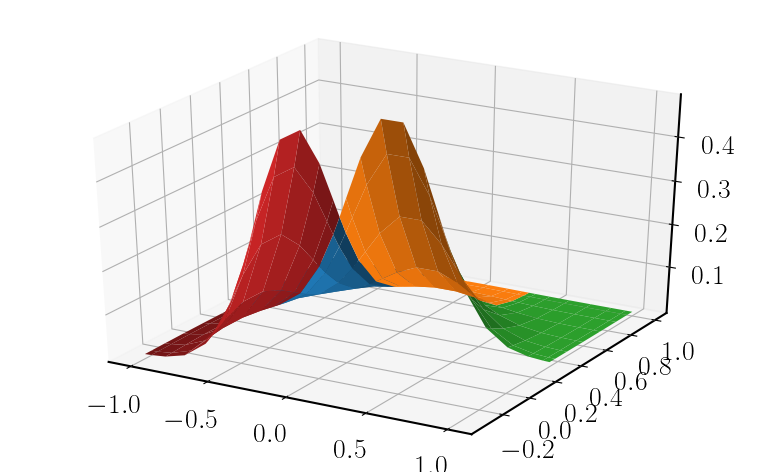

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for idx in np.arange(4):
    ax.plot_surface(np.array(X[idx]), np.array(Y[idx]), np.array(u_init_mesh[idx]))

plt.show()

In [49]:
def lax_friedrichs_flux(u):
    '''
    '''
    u = af.moddims(u, params.N_LGL, params.N_LGL, 3, 3)
    u_left     = u[:, 0, :, :]
    flux_left  = flux_x(u_left)
    u_right    = af.shift(u[:, -1, :, :], d0=0, d1=0, d2=1)
    flux_right = flux_x(u_right)

    flux_vert_boundary = (flux_left + flux_right) / 2 - c_lax * (u_left - u_right)
    print(flux_vert_boundary)
    u_top       = u[0, :, :, :]
    flux_top    = flux_y(u_top)
    u_bottom    = af.shift(u[-1, :, :, :], d0=0, d1=0, d2=0, d3=1)
    flux_bottom = flux_y(u_bottom)

    flux_hor_boundary = (flux_top + flux_bottom) / 2 - c_lax * (u_bottom - u_top)
    print(flux_hor_boundary)
    return

In [24]:
print((u_init))

[arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,), arrayfire.Array()
Type: double
Dims: (64,)]


In [25]:
print(u_init_mesh[0], u_init_mesh[0][:, 0, :, :], u_init_mesh[0][:, -1, :, :])

arrayfire.Array()
Type: double

[8 8 1 1]
    0.0010     0.0016     0.0047     0.0168     0.0539     0.1260     0.2063     0.2494 
    0.0008     0.0013     0.0039     0.0139     0.0446     0.1042     0.1707     0.2063 
    0.0005     0.0008     0.0024     0.0085     0.0272     0.0636     0.1042     0.1260 
    0.0002     0.0004     0.0010     0.0036     0.0116     0.0272     0.0446     0.0539 
    0.0001     0.0001     0.0003     0.0011     0.0036     0.0085     0.0139     0.0168 
    0.0000     0.0000     0.0001     0.0003     0.0010     0.0024     0.0039     0.0047 
    0.0000     0.0000     0.0000     0.0001     0.0004     0.0008     0.0013     0.0016 
    0.0000     0.0000     0.0000     0.0001     0.0002     0.0005     0.0008     0.0010 

 arrayfire.Array()
Type: double

[8 1 1 1]
    0.0010 
    0.0008 
    0.0005 
    0.0002 
    0.0001 
    0.0000 
    0.0000 
    0.0000 

 arrayfire.Array()
Type: double

[8 1 1 1]
    0.2494 
    0.2063 
    0.1260 
    0.0539 
    0.0168 
  

In [26]:
L_p_1 = lagrange.lagrange_function_value(params.lagrange_coeffs)[:, -1]
L_p_1 = af.flat(af.transpose(af.tile(L_p_1, 1, params.N_LGL)))
L_p_1 = (L_p_1)

L_p_minus1 = lagrange.lagrange_function_value(params.lagrange_coeffs)[:, 0]
L_p_minus1 = af.flat(af.transpose(af.tile(L_p_minus1, 1, params.N_LGL)))
L_p_minus1 = (L_p_minus1)

L_q_1 = lagrange.lagrange_function_value(params.lagrange_coeffs)[:, 0]
L_q_1 = af.tile(L_q_1, params.N_LGL)
L_q_1 = (L_q_1)

L_q_minus_1 = lagrange.lagrange_function_value(params.lagrange_coeffs)[:, -1]
L_q_minus_1 = af.tile(L_q_minus_1, params.N_LGL)
L_q_minus_1 = (L_q_minus_1)
print(L_p_1)

arrayfire.Array()
Type: double

[64 1 1 1]
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
    0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
   -0.0000 
    1.0000 
    1.0000 
    1.0000 
    1.0000 
    1.0000 
    1.0000 
    1.0000 
    1.0000 




In [27]:
lagrange_function_value = lagrange.lagrange_function_value(params.lagrange_coeffs)
print(lagrange.integrate(params.lagrange_coeffs))

arrayfire.Array()
Type: double

[8 1 1 1]
    0.0357 
    0.2107 
    0.3411 
    0.4125 
    0.4125 
    0.3411 
    0.2107 
    0.0357 




In [28]:
def surface_term_xi_1(u):
    '''
    '''
    u_xi_1   = u
    flux_xi  = F_xi(u_xi_1)
    flux_eta = F_eta(u_xi_1)
    
    flux_xi_g_00  = g_ab[0][0] * flux_xi
    flux_eta_g_10 = g_ab[1][0] * flux_eta
    
    
    int_Lq = (lagrange.integrate(params.lagrange_coeffs))
    print(int_Lq.shape, L_p_1.shape)
    Lp_Lq  = af.broadcast(utils.multiply, int_Lq, L_p_1)
    surface_term = (int_Lq * flux_xi_g_00)
    
    return surface_term

In [29]:
#print(F_xi(u_init[0]))
u_init_vectorize = af.np_to_af_array(np.zeros([params.N_LGL ** 2, 3, 3]))
for i in range(3):
    for j in range(3):
        u_init_vectorize[:, i, j] = u_init[3 * i + j]

In [30]:
g_ab = g_uu(nodes[elements[0]][:, 0], nodes[elements[0]][:, 1], xi, eta)

In [31]:
print(g_ab[0][0][-params.N_LGL:])

arrayfire.Array()
Type: double

[8 1 1 1]
    9.0000 
    9.0000 
    9.0000 
    9.0000 
    9.0000 
    9.0000 
    9.0000 
    9.0000 




In [32]:

print(surface_term_xi_1(u_init[0]))

(8,) (64,)


RuntimeError: In function af::dim4 getOutDims(const af::dim4&, const af::dim4&, bool)
In file src/backend/ArrayInfo.cpp:186
Invalid dimension for argument 1
Expected: ldims[i] == rdims[i] || ldims[i] == 1 || rdims[i] == 1


In [43]:
c_x = 1.
c_lax = 3
c_y = 1.
def flux_x(u):
    return c_x * u
def flux_y(u):
    return c_y * u

In [50]:
print(lax_friedrichs_flux(u_init_vectorize))

arrayfire.Array()
Type: double

[64 1 3 1]
    0.0010 
    0.0037 
    0.0153 
    0.0584 
    0.1884 
    0.4408 
    0.7220 
    0.8727 
   -0.0013 
    0.0013 
    0.0116 
    0.0479 
    0.1557 
    0.3647 
    0.5973 
    0.7220 
   -0.0101 
   -0.0069 
    0.0024 
    0.0272 
    0.0944 
    0.2225 
    0.3647 
    0.4408 
   -0.0414 
   -0.0336 
   -0.0177 
    0.0036 
    0.0379 
    0.0944 
    0.1557 
    0.1884 
   -0.1344 
   -0.1110 
   -0.0669 
   -0.0251 
    0.0036 
    0.0272 
    0.0479 
    0.0584 
   -0.3149 
   -0.2604 
   -0.1588 
   -0.0669 
   -0.0177 
    0.0024 
    0.0116 
    0.0153 
   -0.5157 
   -0.4266 
   -0.2604 
   -0.1110 
   -0.0336 
   -0.0069 
    0.0013 
    0.0037 
   -0.6234 
   -0.5157 
   -0.3149 
   -0.1344 
   -0.0414 
   -0.0101 
   -0.0013 
    0.0010 

   -0.6234 
   -0.5157 
   -0.3149 
   -0.1344 
   -0.0414 
   -0.0101 
   -0.0013 
    0.0010 
   -0.7365 
   -0.6093 
   -0.3719 
   -0.1587 
   -0.0485 
   -0.0110 
   -0.0001 
    0.00